# Distracted Driver Classification
### By Satchel Grant

The goal of this notebook is to classify the distraction type of the driver of a car. For my personal purposes, I wanted to try implementing a multiple parallel filters into a single convolutional layer.

## Initial Imports

In [1]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.utils import shuffle
import pickle
import scipy.misc as sci

%matplotlib inline

def show_img(img):
    plt.imshow(img)
    plt.show()

## Read in Data
I read the images in from jpg format to numpy array using matplotlib.image's imread function. I wanted to see what each of the driver positions looked like, so I displayed an image from each class. The image size was initially taking up a lot of RAM with an unnecessary amount of detail. I played around with resizing and decided that 120x120 would give good enough clarity for classification. The square sizing also makes the neural net architecture slightly easier to create later in the notebook.

In [2]:
external_drive_path = '/Volumes/WhiteElephant/'
home_path = os.getcwd()
os.chdir(external_drive_path)

In [3]:
path = './statefarm_drivers/imgs/train'

label_types = []
img_files = dict()
for dir_name, subdir_list, file_list in os.walk(path):
    if len(subdir_list) > 0:
        label_types = subdir_list
        for subdir in subdir_list:
            img_files[subdir] = []
    for img_file in file_list:
        if '.jpg' in img_file.lower():
            img_files[dir_name[-2:]].append(os.path.join(dir_name,img_file))

n_labels = len(label_types)

Classification: 0


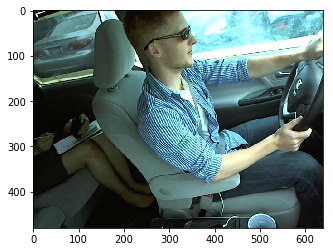

Resized to (120, 120)


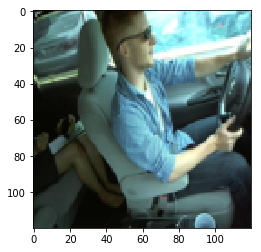

Classification: 1


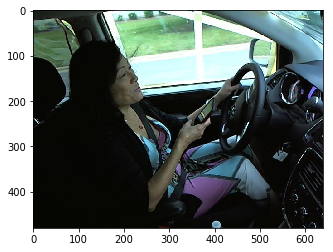

Resized to (120, 120)


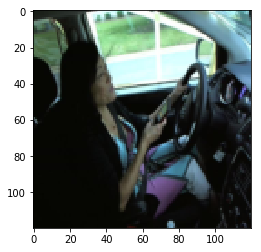

Classification: 2


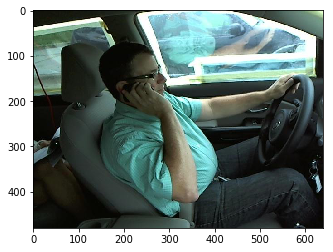

Resized to (120, 120)


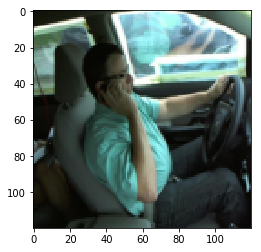

Classification: 3


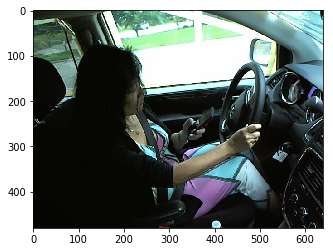

Resized to (120, 120)


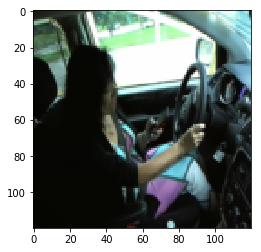

Classification: 4


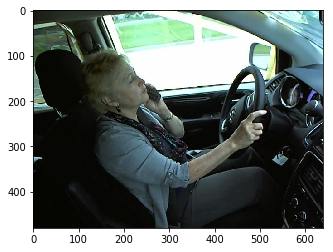

Resized to (120, 120)


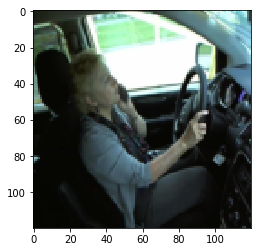

Classification: 5


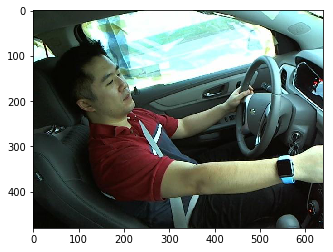

Resized to (120, 120)


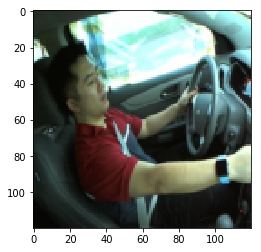

Classification: 6


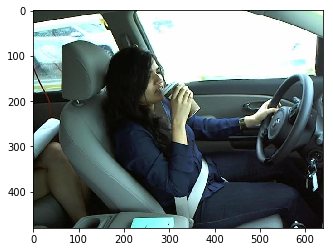

Resized to (120, 120)


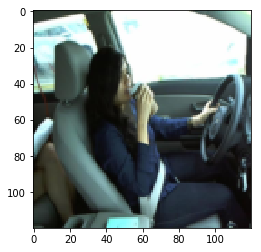

Classification: 7


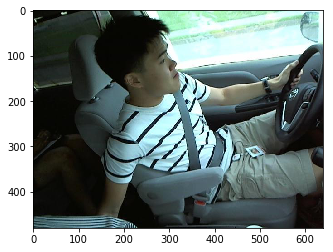

Resized to (120, 120)


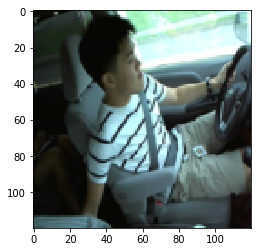

Classification: 8


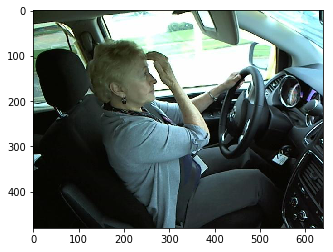

Resized to (120, 120)


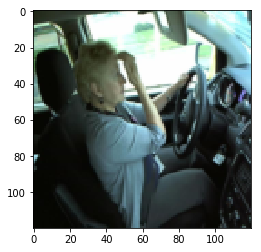

Classification: 9


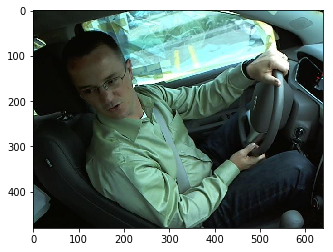

Resized to (120, 120)


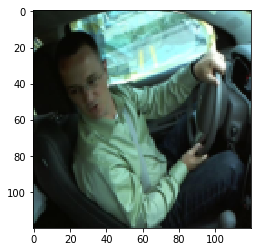

In [4]:
images = []
labels = []
counter = 0
resize_dims = (120, 120)
for i,label in enumerate(label_types):
    files = img_files[label]
    for file in files:
        img = mpimg.imread(file)
        sized_img = sci.imresize(img, resize_dims)
        images.append(sized_img)
        labels.append(i)
        if counter == i:
            counter+=1
            print("Classification: " + str(labels[-1]) + " (" + str(img.shape) + ")")
            show_img(img)
            print("Resized to " + str(resize_dims))
            show_img(sized_img)
del img_files

In [5]:
images = np.array(images, dtype=np.float32)
labels = np.array(labels, dtype=np.float32)

In [6]:
img_shape = images[0].shape
print("Total Image Count: " + str(len(images)))
print("Image Shape: " + str('x'.join([str(s) for s in img_shape])))

Total Image Count: 22424
Image Shape: 120x120x3


### Split into Training and Validation Sets
I split the images into a training, validation, and testing set and saved them as pickle files so as to easily draw on them when restarting the notebook kernel. It does not matter if the training and validation sets mix, but if the testing set is to get mixed with the others, it can potentially ruin its credibility as a final test. This is because the tuning of the hyperparameters viewing the model's performance on the test data can affect hyperparameter choices which can then result in slightly overfitting the test data. This is why it was important to seperate the datasets and keep them seperate.

In [7]:
## Split Into Training and Validation

images, labels = shuffle(images, labels)

split_index = int(len(images)*.67)

train_images = images[:split_index]
train_labels = labels[:split_index]
valid_images = images[split_index:]
valid_labels = labels[split_index:]

del images
del labels

In [ ]:
print("Training set size: " + str(train_images.shape[0]))
print("Validation set size: " + str(valid_images.shape[0]))

### Understanding the Data
It is important to have equally distributed image classes so that the classifier does not favor one type of class over another. It is also important to ensure that each data set has a similar distribution of image types so that we can be sure that we are training and testing for all classes.


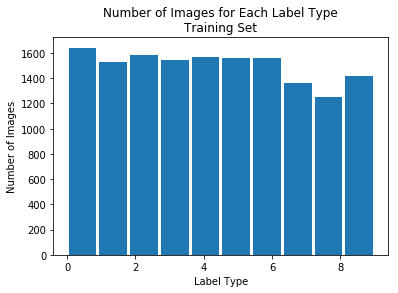

In [8]:
## Label Distributions

plt.hist(train_labels, 10, rwidth=.9)
plt.ylabel("Number of Images")
plt.xlabel("Label Type")
plt.title("Number of Images for Each Label Type\nTraining Set")
plt.show()

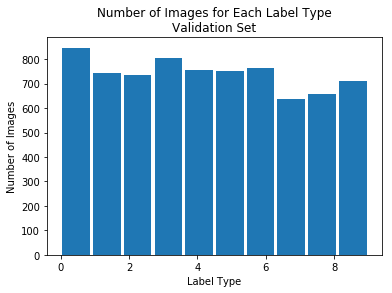

In [9]:
plt.hist(valid_labels, 10, rwidth=.9)
plt.ylabel("Number of Images")
plt.xlabel("Label Type")
plt.title("Number of Images for Each Label Type\nValidation Set")
plt.show()

## Preprocessing
The main preprocessing step I used was to center and normalize the pixel values for each image. I used the mean and standard deviation from a single dataset for all dataset preprocessing so that each image would maintain its relative pixel values. Using different means and different standard deviations could potentially skew an image's coloring relative to the coloring that the classifier was trained on.

At this point, I have not tried training my classifier on gray versions of the images. This is due to lack of time and resources.

I also considered adding scaled and/or rotated copies of the training images to boost the size of the dataset. I considered both to be last resort, however, for a few reasons. I was working with limited RAM space and too many image additions would be more than my computer could handle. I figured, also, that rotations could potentially provide little training improvement because each image has a similar angle with respect to the car. Thus variation in the rotation of the image could impose undo stress on the classifier's learning. Similarly, scaling could be of little value given that each image is taken from approximately the same distance from the driver. Despite these theories, my guess is that adding fake data would improve results, but I did not get around to trying due to time and resource constraints. 

In [10]:
PROCESS_MEAN = np.mean(train_images)
PROCESS_DEV = np.std(train_images)

def gray(images):
    return np.mean(images,-1) ## Not standard gray format, but should work fine for preprocessing purposes

def centernorm(images):
    return (images-PROCESS_MEAN)/PROCESS_DEV

def one_hot_encode(labels, n_labels):
    encoded_labels = np.zeros((labels.shape[0], n_labels), dtype=np.float32)
    for i,label in enumerate(labels):
        encoded_labels[i,int(label)] = 1
    return encoded_labels

def preprocess(images, labels, n_labels, make_gray=False):
    if make_gray:
        images = gray(images)
    images = centernorm(images)
    labels = one_hot_encode(labels, n_labels)
    if make_gray: return np.reshape(images,[s for s in images.shape]+[1]), labels
    return images, labels
        

In [11]:
train_images, train_labels = preprocess(train_images, train_labels, n_labels)
valid_images, valid_labels = preprocess(valid_images, valid_labels, n_labels)

## Define Neural Net Architecture
This is the part that I really wanted to experiment with. I heard a little about the inception net architecture which gave me the idea for parallel convolution kernels. The inception net uses multiple types of convolution structures on a single layer of activations. I simplified the idea to a 1x1, 3x3, and 5x5 convolution kernel followed by a max pooling for the first 3 layers in the net. I then finish the net with two fully connected layers after using a dropout layer between the convolution and fully connected sections.

In [12]:
img_depth = train_images.shape[-1]

w1_depth = 6
weight_shapes1 = [
    # Start: 120x120
    (5,5,img_depth,w1_depth),
    (3,3,img_depth,w1_depth),
    (1,1,img_depth,w1_depth),
    # Max Pool: 60x60
]

w2_depth = 8
weight_shapes2 = [
    # Start: 60x60
    (5,5,len(weight_shapes1)*w1_depth,w2_depth),
    (3,3,len(weight_shapes1)*w1_depth,w2_depth),
    (1,1,len(weight_shapes1)*w1_depth,w2_depth),
    # Max Pool: 30x30
]

w3_depth = 8
weight_shapes3 = [
    # Start: 30x30
    (5,5,len(weight_shapes2)*w2_depth,w3_depth),
    (3,3,len(weight_shapes2)*w2_depth,w3_depth),
    (1,1,len(weight_shapes2)*w2_depth,w3_depth),
    # Max Pool: 15x15
]

fc_weight_shapes = [
    (15*15*len(weight_shapes3)*w3_depth, 100),
    (100,n_labels)
]

weight_shapes = [weight_shapes1, weight_shapes2, weight_shapes3]
convweights = [[tf.Variable(tf.truncated_normal(shape=x,mean=0,stddev=0.1)) for x in weight_shape]\
               for weight_shape in weight_shapes]

print(convweights)

convbiases = [[tf.Variable(tf.zeros([x[-1]])) for x in weight_shape] for weight_shape in weight_shapes]

fc_weights = [tf.Variable(tf.truncated_normal(shape=x, mean=0, stddev=0.1)) for x in fc_weight_shapes]
fc_biases = [tf.Variable(tf.zeros([x[-1]])) for x in fc_weight_shapes]


[[<tensorflow.python.ops.variables.Variable object at 0x121dcd9e8>, <tensorflow.python.ops.variables.Variable object at 0x11ec0eb70>, <tensorflow.python.ops.variables.Variable object at 0x121d50fd0>], [<tensorflow.python.ops.variables.Variable object at 0x1214fae80>, <tensorflow.python.ops.variables.Variable object at 0x121ced9b0>, <tensorflow.python.ops.variables.Variable object at 0x1218107b8>], [<tensorflow.python.ops.variables.Variable object at 0x121856828>, <tensorflow.python.ops.variables.Variable object at 0x121856978>, <tensorflow.python.ops.variables.Variable object at 0x12150f7f0>]]


In [13]:
def param_count(weight_shapes):
    total = 0
    for shape in weight_shapes:
        params = 1
        for dim in shape:
            params *= dim
        total += params + shape[-1]
    return total

total_params = 0
for weight_shape in weight_shapes:
    total_params += param_count(weight_shape)
    
print('Total params: {}'.format(total_params))

Total params: 12456


In [16]:
def conv2d(activations, weight, bias, stride=1, padding="SAME"):
    layer = tf.nn.bias_add(tf.nn.conv2d(activations, weight, strides=[1,stride,stride,1],padding=padding), bias)
    return tf.nn.elu(layer)

def max_pool(activations, k=2):
    return tf.nn.max_pool(activations, ksize=[1,k,k,1],strides=[1,k,k,1],padding='VALID')

def conv_pass(activations, weights, biases, padding="SAME"):
    layers = []
    for weight,bias in zip(weights,biases):
        layers.append(conv2d(activations,weight,bias,padding=padding))
    logits = tf.concat(layers,3)
    return max_pool(logits)

def fc_net(data, weights, biases):
    logits = data
    for i in range(len(weights)):
        logits = tf.matmul(logits, weights[i]) + biases[i]
        if i < len(weights)-1:
            logits = tf.nn.relu(logits)
    return tf.nn.softmax(logits)


In [48]:
data_features = tf.placeholder(tf.float32, [None,120,120,3])
data_labels = tf.placeholder(tf.float32, [None, n_labels])
dropout = tf.placeholder(tf.float32)

logits = data_features
for weights,biases in zip(convweights, convbiases):
    logits = conv_pass(logits, weights, biases)

logits = tf.nn.dropout(logits,dropout)
logits = tf.reshape(logits, [-1, fc_weights[0].get_shape().as_list()[0]])

logits = fc_net(logits, fc_weights, fc_biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=data_labels))
optimizer = tf.train.AdamOptimizer().minimize(cost)

equal_list = tf.equal(tf.argmax(logits,1), tf.argmax(data_labels,1))
accuracy = tf.reduce_mean(tf.cast(equal_list, tf.float32))

save_file = './net_model'
saver = tf.train.Saver()

init = tf.global_variables_initializer()

## Run Session

In [21]:
epochs = 40
batch_size = 128
dropout_prob = .5

with tf.Session() as sess:
    print("Session Start")   
    sess.run(init)
    n_batches = train_images.shape[0]//batch_size
    loss = []
    for epoch in range(epochs):
        train_images, train_labels = shuffle(train_images, train_labels)
        running_cost = 0
        for batch in range(1,n_batches):
            batch_x = train_images[batch*batch_size-batch_size:batch*batch_size]
            batch_y = train_labels[batch*batch_size-batch_size:batch*batch_size]
            optcost = sess.run([optimizer,cost], 
                               feed_dict={dropout: dropout_prob, data_features: batch_x, data_labels: batch_y})
            running_cost += optcost[1]
        loss.append(running_cost)
        print("Epoch: " + str(epoch+1))
        print("Training Cost: " + str(running_cost))
        valid_images, valid_labels = shuffle(valid_images, valid_labels)
        accost = sess.run([accuracy,cost], 
                          feed_dict={dropout: 1., data_features: valid_images[:250], data_labels: valid_labels[:250]})
        print("Cost: " + str(accost[1]) + ", Accuracy: " + str(accost[0]))
    
    saver.save(sess,save_file)


Session Start
Epoch: 1
Training Cost: 246.8282547
Cost: 1.88987, Accuracy: 0.584
Epoch: 2
Training Cost: 209.013470173
Cost: 1.68559, Accuracy: 0.776
Epoch: 3
Training Cost: 197.337731838
Cost: 1.69964, Accuracy: 0.76
Epoch: 4
Training Cost: 193.928219438
Cost: 1.64701, Accuracy: 0.812
Epoch: 5
Training Cost: 191.506679535
Cost: 1.61124, Accuracy: 0.852
Epoch: 6
Training Cost: 189.751722217
Cost: 1.63838, Accuracy: 0.82
Epoch: 7
Training Cost: 188.131225228
Cost: 1.58719, Accuracy: 0.876
Epoch: 8
Training Cost: 186.262192369
Cost: 1.59255, Accuracy: 0.868
Epoch: 9
Training Cost: 184.55584383
Cost: 1.57765, Accuracy: 0.884
Epoch: 10
Training Cost: 183.081686258
Cost: 1.57648, Accuracy: 0.884
Epoch: 11
Training Cost: 182.239279151
Cost: 1.54296, Accuracy: 0.916
Epoch: 12
Training Cost: 181.458185554
Cost: 1.57699, Accuracy: 0.884
Epoch: 13
Training Cost: 181.208523154
Cost: 1.55906, Accuracy: 0.9
Epoch: 14
Training Cost: 180.91454792
Cost: 1.54872, Accuracy: 0.912
Epoch: 15
Training Cost

NameError: name 'valid_data' is not defined

The cell output above ends in an error because of a typo in the validation evaluation. This was actually a lucky typo because the notebook was about to try to run the entire validation set in a single batch which requires more memory than my setup can handle (without paying for an AWS instance that is!).


Loss chart from training session


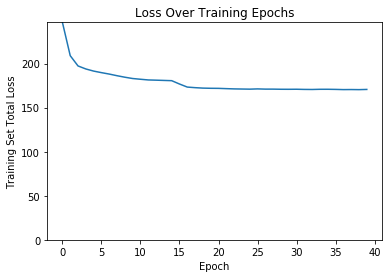

In [25]:
print('\nLoss chart from training session')
plt.plot(np.arange(len(loss)), loss)
plt.ylim([0,loss[0]])
plt.title("Loss Over Training Epochs")
plt.ylabel("Training Set Total Loss")
plt.xlabel("Epoch")
plt.show()

## Model Validation
The next cell tests the model on the entire validation set in batches so as to minimize RAM usage.

In [24]:
## Check validation set

with tf.Session() as sess:
    print("Session Start")
    saver.restore(sess, save_file)
    valid_images, valid_labels = shuffle(valid_images, valid_labels)
    ## Batch Evaluation
    total_accuracy = 0
    batch_size = 400
    n_batches = valid_images.shape[0]//500
    for batch in range(n_batches): 
        index = batch*batch_size
        batch_x = valid_images[index:index+batch_size]
        batch_y = valid_labels[index:index+batch_size]
        acc = sess.run(accuracy, feed_dict={dropout: 1., data_features: batch_x, data_labels: batch_y})
        total_accuracy += acc
    total_accuracy = total_accuracy/n_batches
    print("Validation Accuracy: " + str(total_accuracy))

Session Start
Validation Accuracy: 0.990892865828


Woohoo! 99% accuracy is pretty good! But this is just the validation set. Hopefully the test set will be just as good.

## Prepare Kaggle Submission
The next few cells prepare the kaggle submission. First I read and preprocess the images. Then I run them through the classifier and output predictions.

In [27]:
## Read In Images

path = './statefarm_drivers/imgs/test'

img_files = []
for dir_name, subdir_list, file_list in os.walk(path):
    for img_file in file_list:
        if '.jpg' in img_file.lower():
            img_files.append(os.path.join(dir_name,img_file))


In [29]:
print("Number of images: " + str(len(img_files)))

Number of images: 79726


Given the large number of testing images (79726), the testing had to be done in batches so as to avoid reaching memory limits.

In [51]:
batch_size = 500
n_batches = len(img_files)//batch_size+1
resize_dims = (120, 120)

with tf.Session() as sess:
    saver.restore(sess, save_file)
    for batch in range(n_batches):
        images = []
        if batch % 30 == 0: print('Batch: ' + str(batch))
        index = batch*batch_size
        batch_ids = []
        for file in img_files[index:index+batch_size]:
            img = mpimg.imread(file)
            sized_img = sci.imresize(img, resize_dims)
            images.append(sized_img)
            batch_ids.append(file.split('/')[-1]) ## Ids are just the jpg file names
        images = np.array(images, dtype=np.float32)
        images = centernorm(images)

        if batch % 30 == 0: print('Session Start')
        logits_ = sess.run(logits, feed_dict={dropout: 1., data_features: images})

        if batch % 30 == 0: print('Writing to File')
        with open('./statefarm_drivers/submission.csv', 'a') as f:
            for i,logit in enumerate(logits_):
                id_ = batch_ids[i]        
                f.write(id_+',')
                for j,el in enumerate(logit):
                    if j == logit.shape[0]-1: f.write(str(el)+'\n')
                    else: f.write(str(el)+',')
        if batch % 30 == 0: print('End Writing to File')

Batch: 0
Session Start
Writing to File
End Writing to File
Session Start
Writing to File
End Writing to File
Batch: 30
Session Start
Writing to File
End Writing to File
Batch: 60
Session Start
Writing to File
End Writing to File
Session Start
Writing to File
End Writing to File
Batch: 90
Session Start
Writing to File
End Writing to File
Batch: 120
Session Start
Writing to File
End Writing to File
Session Start
Writing to File
End Writing to File
Batch: 150


The final submission log loss value was 2.9 on Kaggle. I believe my model is better than this, however, and the log loss is skewed by the confidence of the model. I will investigate further 